# Projet 6

In [11]:
import random
import os
# notre package de fonctionnalités
from Package import Scripts_Analyse01 as pk
import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
from scipy.stats import pearsonr
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.features import ParallelCoordinates
from plotly.graph_objects import Layout
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.features import PCA as PCA_yellow
from yellowbrick.style import set_palette
from sklearn import metrics
import gc
import time
from contextlib import contextmanager
import warnings
import numpy as np
from datetime import datetime
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
from dotenv import load_dotenv
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [2]:
%flake8_off

ValueError: Function <bound method VarWatcher.auto_run_flake8 of <pycodestyle_magic.VarWatcher object at 0x000001EAFB3930A0>> is not registered as a post_run_cell callback

In [12]:
# chargement des variables d'environnment
load_dotenv() 

Python-dotenv could not parse statement starting at line 1


True

# Collecte des données

In [13]:
api_key = os.getenv('API_KEY')
endpoint = "https://api.yelp.com/v3/graphql"

Réalisons une fonction pour réaliser des requêtes en GraphQL. On utilise cette solution afin de pouvoir collecter les informations uniquement des champs qui nous intéressent.

In [14]:
def request_client(api_key, endpoint, query):
    reqHeaders = {
        'Authorization': 'Bearer ' + api_key 
    }

    _transport = RequestsHTTPTransport(
        url=endpoint,
        headers = reqHeaders,
        use_json=True,
    )

    client = Client(
        transport = _transport,
        fetch_schema_from_transport=True,
    )

    result = client.execute(query)
    return result

In [15]:
# le max de review est de 3 par restaurant, on importe toutes les données
restaurants=[]
j = 0
for i in range(0,4):
    query = """
                {
                search(term:"restaurant",
                        location:"FR"
                        limit:50,
                        offset:"""+str(j)+"""
                        ) {
                    business {
                    id,
                    name,
                    photos,
                    reviews{
                        id,
                        text,
                        rating
                    }
                    }
                }
                }
            """
    query = gql(query)
    temp = request_client(api_key, endpoint, query)["search"]["business"]
    restaurants.extend(temp)
    print("nb restaurants ", len(restaurants))
    j=j+51
    

nb restaurants  50
nb restaurants  100
nb restaurants  150
nb restaurants  200


In [16]:
restaurants = pd.DataFrame(restaurants)

Nous exportons les données au format csv pour les sauvegarder

In [17]:
restaurants.to_csv('output/restaurants.csv')

# Construction des bases de données

On scinde notre fichier en deux afin de traiter le texte et les photos séparément.

In [18]:
for i in restaurants["reviews"].head():
    print(i)

[{'id': 'aGP7nLwEQOUg64jKP8ebsw', 'text': 'My favorite meal in Paris! \n\nWe started off with the foie gras carpaccio and escargot. Love the unique way that the foie gras was prepared and so thinly...', 'rating': 5}, {'id': 'SZtFX-6RF0fLrJjFEyM2XQ', 'text': 'Warning! Tourist trap restaurant.  This restaurant is highly overrated, so do not go by the deceiving ratings.  I had probably one of the worst and...', 'rating': 1}, {'id': 'ctNB1g1MjXibFPrXuyGyIw', 'text': "Best dining experience in paris! The food was imo really unique and things I didn't see around paris often. We didn't make a res so came super early at...", 'rating': 5}]
[{'id': '-to6adg_kucf1SgQckgJXw', 'text': 'This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or dinner if I am close by. The hostess is very friendly. The...', 'rating': 5}, {'id': 'G-YvPO-wUd-NIJDrahcYUg', 'text': 'what a wonderful lunch! \nthe decor is so french! and the staff is very nice and accommodating! \nwe h

In [19]:
df = restaurants.copy()

In [20]:
df['reviews'].apply(pd.Series)[0].apply(pd.Series)

,id,text,rating
0,aGP7nLwEQOUg64jKP8ebsw,My favorite meal in Paris! \n\nWe started off ...,5
1,-to6adg_kucf1SgQckgJXw,This is a small bar/restaurant closed to Cathé...,5
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",5
3,U8G3f8ITSlqBzETBDVO8bw,"Foods were delicious, great ambiance, and help...",5
4,giErkj8Al6-egq5XUu2FqA,Michelin starred. Reservations weeks in advanc...,5
...,...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,OH EMM GEEE! Make sure you schedule a moment t...,5
196,uJ6hdwRTutiWk0Mg4XduEQ,The chicken here is done extremely well! The c...,5
197,hH_CO0dpAgIphCSbufJO8Q,Excellent food and what a great find in Opera ...,5
198,CT26f0OH_6pntDsvQ0ecpw,This restaurant is basically across the street...,5


In [21]:
df = pd.concat([df.drop(['reviews'], axis=1), 
    df['reviews'].apply(pd.Series)[0].apply(pd.Series)]
    , axis=1)
df.columns = ['id', 'name', 'photos', 'rw_id', 'rw_text',
          'rw_rating']

In [22]:
df.to_csv('output/restaurants_v2.csv')

In [487]:
reviews = df[["rw_id", "rw_text"]].copy()

In [24]:
photos = df[["id", "photos"]]

# Analyse des données

## Pré traitement des données textuelles

Analysons le texte en premier lieu

In [25]:
from collections import defaultdict

tokenizer = nltk.RegexpTokenizer(r'\w+')
tokenizer.tokenize("This is a small bar/restaurant closed to Cathédrale Notre Dame. I always come here for lunch or dinner if I am close by. The hostess is very friendly. The...")
tokenizer = nltk.RegexpTokenizer(r'\w+')


Le but est de découvrir les sujets insatisfaisants, nous commençons par compter le nombre de mots.

In [26]:
reviews

,rw_id,rw_text
0,aGP7nLwEQOUg64jKP8ebsw,My favorite meal in Paris! \n\nWe started off ...
1,-to6adg_kucf1SgQckgJXw,This is a small bar/restaurant closed to Cathé...
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ..."
3,U8G3f8ITSlqBzETBDVO8bw,"Foods were delicious, great ambiance, and help..."
4,giErkj8Al6-egq5XUu2FqA,Michelin starred. Reservations weeks in advanc...
...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,OH EMM GEEE! Make sure you schedule a moment t...
196,uJ6hdwRTutiWk0Mg4XduEQ,The chicken here is done extremely well! The c...
197,hH_CO0dpAgIphCSbufJO8Q,Excellent food and what a great find in Opera ...
198,CT26f0OH_6pntDsvQ0ecpw,This restaurant is basically across the street...


In [488]:
reviews["rw_text"] = reviews["rw_text"].str.lower()
for index, element in reviews.iterrows():
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(element["rw_text"])
    reviews.loc[index, "nb_words"] = len(tokens)
    reviews.loc[index, "words"] = str(tokens)

In [86]:
reviews

,rw_id,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'..."
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran..."
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '..."
3,U8G3f8ITSlqBzETBDVO8bw,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia..."
4,giErkj8Al6-egq5XUu2FqA,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,oh emm geee! make sure you schedule a moment t...,32.0,"['oh', 'emm', 'geee', 'make', 'sure', 'you', '..."
196,uJ6hdwRTutiWk0Mg4XduEQ,the chicken here is done extremely well! the c...,30.0,"['the', 'chicken', 'here', 'is', 'done', 'extr..."
197,hH_CO0dpAgIphCSbufJO8Q,excellent food and what a great find in opera ...,24.0,"['excellent', 'food', 'and', 'what', 'a', 'gre..."
198,CT26f0OH_6pntDsvQ0ecpw,this restaurant is basically across the street...,29.0,"['this', 'restaurant', 'is', 'basically', 'acr..."


In [29]:
graph = reviews.sort_values(by='nb_words', ascending=False)
pk.graph_intv_bar(graph, 'rw_id', 'nb_words', "rw_id", "nb words", 'redor', "Nombre de mots par commentaire")

Regardons les mots les plus fréquents

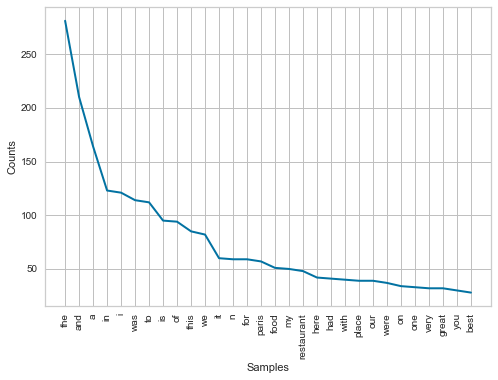

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [93]:
word_mostfreq = str(list(reviews["rw_text"]))
fdist = nltk.FreqDist(tokenizer.tokenize(word_mostfreq))
fdist.plot(30)

Réalisons une fonction.

In [94]:
def nb_most_frequent_plt(df_var):
    word_mostfreq = str(list(df_var))
    fdist = nltk.FreqDist(tokenizer.tokenize(word_mostfreq))
    fdist.plot(30)

Nous observons des mots communs comme "the" qui ne seront pas utiles.

In [486]:
gc.collect()

64313

In [489]:
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aurel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dans la liste stopwords du package, il y a des mots qui sont importants pour l'identification des sentiments comme "very" ou les négations ("not"...)
Supprimons ces éléments de la liste de stopwords.

In [490]:
keep_words = ["you're", "you've", "you'll", "you'd", 
"she's", "it's", "that'll", 'is', 'are', 
  'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
  'doing', 'on', 'off', 'again', 'further', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've",
     'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
      "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', 
      "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
      'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
new_sw_nltk = [word for word in sw_nltk if word not in keep_words]

In [491]:
new_sw_nltk.append("paris")

Ces mots n'apportent pas de sens concernant les sentiments dans les phrases. Autrement dit, ce sont des mots dit vides pour notre projet.

In [492]:
reviews

,rw_id,rw_text,nb_words,words
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'..."
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran..."
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '..."
3,U8G3f8ITSlqBzETBDVO8bw,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia..."
4,giErkj8Al6-egq5XUu2FqA,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,oh emm geee! make sure you schedule a moment t...,32.0,"['oh', 'emm', 'geee', 'make', 'sure', 'you', '..."
196,uJ6hdwRTutiWk0Mg4XduEQ,the chicken here is done extremely well! the c...,30.0,"['the', 'chicken', 'here', 'is', 'done', 'extr..."
197,hH_CO0dpAgIphCSbufJO8Q,excellent food and what a great find in opera ...,24.0,"['excellent', 'food', 'and', 'what', 'a', 'gre..."
198,CT26f0OH_6pntDsvQ0ecpw,this restaurant is basically across the street...,29.0,"['this', 'restaurant', 'is', 'basically', 'acr..."


In [493]:
pat = r'\b(?:{})\b'.format('|'.join(new_sw_nltk))
reviews['new_words'] = reviews['words'].str.replace(pat, '')



In [494]:
reviews

,rw_id,rw_text,nb_words,words,new_words
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'..."
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '..."
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '..."
3,U8G3f8ITSlqBzETBDVO8bw,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia..."
4,giErkj8Al6-egq5XUu2FqA,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,oh emm geee! make sure you schedule a moment t...,32.0,"['oh', 'emm', 'geee', 'make', 'sure', 'you', '...","['oh', 'emm', 'geee', 'make', 'sure', '', 'sch..."
196,uJ6hdwRTutiWk0Mg4XduEQ,the chicken here is done extremely well! the c...,30.0,"['the', 'chicken', 'here', 'is', 'done', 'extr...","['', 'chicken', '', 'is', 'done', 'extremely',..."
197,hH_CO0dpAgIphCSbufJO8Q,excellent food and what a great find in opera ...,24.0,"['excellent', 'food', 'and', 'what', 'a', 'gre...","['excellent', 'food', '', '', '', 'great', 'fi..."
198,CT26f0OH_6pntDsvQ0ecpw,this restaurant is basically across the street...,29.0,"['this', 'restaurant', 'is', 'basically', 'acr...","['', 'restaurant', 'is', 'basically', 'across'..."


Etudions à nouveau les mots les plus fréquents.

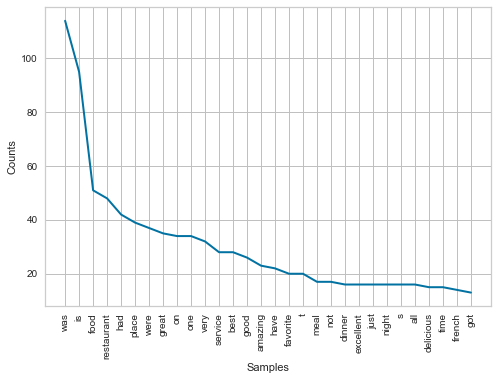

In [468]:
nb_most_frequent_plt(reviews["new_words"])

Nous n'avons plus de mots dit vides. Il nous faut à présent conserver la racine des mots et regarder les trigrammes pour conserver le sens des mots.

In [469]:
reviews

,rw_id,rw_text,nb_words,words,words_ok,new_words
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['favorit', 'meal', 'start', 'off', 'foie', 'g...","['', 'favorite', 'meal', '', '', '', 'started'..."
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['is', 'small', 'bar', 'restaur', 'close', 'ca...","['', 'is', '', 'small', 'bar', 'restaurant', '..."
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['is', 'review', '2019', 'place', 'is', 'perfe...","['', 'is', '', '', 'review', '', '2019', '', '..."
3,U8G3f8ITSlqBzETBDVO8bw,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['food', 'were', 'delici', 'great', 'ambianc',...","['foods', 'were', 'delicious', 'great', 'ambia..."
4,giErkj8Al6-egq5XUu2FqA,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'star', 'reserv', 'week', 'advanc...","['michelin', 'starred', 'reservations', 'weeks..."
...,...,...,...,...,...,...
195,qzZwnApIU_zTLaKxguUUuQ,oh emm geee! make sure you schedule a moment t...,32.0,"['oh', 'emm', 'geee', 'make', 'sure', 'you', '...","['oh', 'emm', 'geee', 'make', 'sure', 'schedul...","['oh', 'emm', 'geee', 'make', 'sure', '', 'sch..."
196,uJ6hdwRTutiWk0Mg4XduEQ,the chicken here is done extremely well! the c...,30.0,"['the', 'chicken', 'here', 'is', 'done', 'extr...","['chicken', 'is', 'done', 'extrem', 'well', 'c...","['', 'chicken', '', 'is', 'done', 'extremely',..."
197,hH_CO0dpAgIphCSbufJO8Q,excellent food and what a great find in opera ...,24.0,"['excellent', 'food', 'and', 'what', 'a', 'gre...","['excel', 'food', 'great', 'find', 'opera', 'd...","['excellent', 'food', '', '', '', 'great', 'fi..."
198,CT26f0OH_6pntDsvQ0ecpw,this restaurant is basically across the street...,29.0,"['this', 'restaurant', 'is', 'basically', 'acr...","['restaur', 'is', 'basic', 'across', 'street',...","['', 'restaurant', 'is', 'basically', 'across'..."


In [515]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='english')

reviews['stemmed'] = reviews['new_words'].apply(lambda x: [stemmer.stem(y).replace("['","''")  for y in list(x.split(", "))])

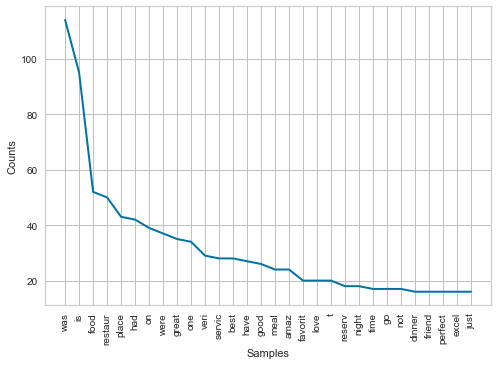

In [471]:
nb_most_frequent_plt(reviews["stemmed"])

Maintenant que nous avons que les racines des mots, réalisons les trigrammes

In [512]:
reviews["stemmed"] = reviews["stemmed"].apply(lambda x: "".join(str(x).split(", "))  )

In [516]:
reviews["stemmed"] 

0      ['', favorit, meal, '', '', '', start, off, ''...
1      ['', is, '', small, bar, restaur, close, '', c...
2      ['', is, '', '', review, '', 2019, '', place, ...
3      [''food, were, delici, great, ambianc, '', hel...
4      [''michelin, star, reserv, week, '', advanc, i...
                             ...                        
195    [''oh, emm, geee, make, sure, '', schedul, '',...
196    ['', chicken, '', is, done, extrem, well, '', ...
197    [''excel, food, '', '', '', great, find, '', o...
198    ['', restaur, is, basic, across, '', street, '...
199    ['', wife, '', '', ran, '', '', place, '', '',...
Name: stemmed, Length: 200, dtype: object

In [517]:
reviews.head(2)

,rw_id,rw_text,nb_words,words,new_words,stemmed,words_ok
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","['', favorit, meal, '', '', '', start, off, ''...",favorit meal start off 1 is small bar restaur ...
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","['', is, '', small, bar, restaur, close, '', c...",favorit meal start off 1 is small bar restaur ...


In [519]:
for index, element in reviews.iterrows():
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(str(element["stemmed"]))
    reviews.loc[index, "words_ok"] = " ".join(tokens)
    # reviews.drop(["new_words", "stemmed"], axis=1)

In [521]:
reviews.head(5)

,rw_id,rw_text,nb_words,words,new_words,stemmed,words_ok
0,aGP7nLwEQOUg64jKP8ebsw,my favorite meal in paris! \n\nwe started off ...,28.0,"['my', 'favorite', 'meal', 'in', 'paris', 'we'...","['', 'favorite', 'meal', '', '', '', 'started'...","['', favorit, meal, '', '', '', start, off, ''...",favorit meal start off foie gras carpaccio esc...
1,-to6adg_kucf1SgQckgJXw,this is a small bar/restaurant closed to cathé...,30.0,"['this', 'is', 'a', 'small', 'bar', 'restauran...","['', 'is', '', 'small', 'bar', 'restaurant', '...","['', is, '', small, bar, restaur, close, '', c...",is small bar restaur close cathédral notr dame...
2,WMRKQUUR3BmjV_EZg7zVfw,"this is for a review from 2019, this place is ...",25.0,"['this', 'is', 'for', 'a', 'review', 'from', '...","['', 'is', '', '', 'review', '', '2019', '', '...","['', is, '', '', review, '', 2019, '', place, ...",is review 2019 place is perfect would recommen...
3,U8G3f8ITSlqBzETBDVO8bw,"foods were delicious, great ambiance, and help...",24.0,"['foods', 'were', 'delicious', 'great', 'ambia...","['foods', 'were', 'delicious', 'great', 'ambia...","[''food, were, delici, great, ambianc, '', hel...",food were delici great ambianc help staff riso...
4,giErkj8Al6-egq5XUu2FqA,michelin starred. reservations weeks in advanc...,23.0,"['michelin', 'starred', 'reservations', 'weeks...","['michelin', 'starred', 'reservations', 'weeks...","[''michelin, star, reserv, week, '', advanc, i...",michelin star reserv week advanc is absolut ne...


In [522]:
trigrams_all= []
for element in reviews["words_ok"]:
    token = nltk.word_tokenize(element)
    trigrams = ngrams(token,3)
    trigrams_all.append(list(trigrams))
    break
trigrams_all

[[('favorit', 'meal', 'start'), ('meal', 'start', 'off'), ('start', 'off', 'foie'), ('off', 'foie', 'gras'), ('foie', 'gras', 'carpaccio'), ('gras', 'carpaccio', 'escargot'), ('carpaccio', 'escargot', 'love'), ('escargot', 'love', 'uniqu'), ('love', 'uniqu', 'way'), ('uniqu', 'way', 'foie'), ('way', 'foie', 'gras'), ('foie', 'gras', 'was'), ('gras', 'was', 'prepar'), ('was', 'prepar', 'thinly')]]